In [187]:
%run helpers.py
%run helpers-Copy1.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Executive Summary

### So What?

In [188]:
data=pd.read_excel('./cleaned.xls')

In [189]:
data.columns

Index([u'area', u'class', u'company', u'date', u'description', u'job_id',
       u'level', u'location', u'salary', u'sub_class', u'title', u'type'],
      dtype='object')

In [190]:
print data.shape
print data.info()
data.head()

(4335, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4335 entries, 0 to 4334
Data columns (total 12 columns):
area           4335 non-null object
class          4335 non-null object
company        4335 non-null object
date           4335 non-null datetime64[ns]
description    4335 non-null object
job_id         4335 non-null int64
level          4335 non-null object
location       4335 non-null object
salary         4335 non-null int64
sub_class      4335 non-null object
title          4335 non-null object
type           4335 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 440.3+ KB
None


,area,class,company,date,description,job_id,level,location,salary,sub_class,title,type
0,Southern Suburbs & Logan,Information & Communication Technology,Opus Recruitment Solutions,2017-12-21,DATA SCIENCE SUPERSTARS\r\n\r\nMODERN OFFICES\...,35131268,normalJob,Sydney,384,Database Development & Administration,Data Science Leads,Full Time
1,North Shore & Northern Beaches,Information & Communication Technology,Spark Recruitment,2017-12-21,Take ownership for the strategic development o...,35130098,normalJob,Sydney,576,Product Management & Development,Product Manager - Big Data / Data Analytics,Full Time
2,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,2XM Technology Pty Ltd,2017-12-21,Data Solution Architect required to work on a ...,35129596,normalJob,Sydney,615,Architects,Big Data Solution Architect,Full Time
3,CBD & Inner Suburbs,Engineering,Employment Office,2017-12-21,Are you an experienced Surveyor looking for an...,35131526,normalJob,Melbourne,269,Project Engineering,Surveyor Data Manager,Full Time
4,CBD & Inner Suburbs,Engineering,Employment Office,2017-12-21,Are you an experienced Surveyor looking for an...,35131487,normalJob,Melbourne,269,Civil/Structural Engineering,Surveyor Data Manager,Full Time


In [191]:
print len(data['area'].value_counts())
print len(data['class'].value_counts())
print len(data['sub_class'].value_counts())
print len(data['company'].value_counts())

19
30
258
1110


### Dummy Creation

In [192]:
location_dummy = pd.get_dummies(data.location, prefix='location',drop_first=True)
type_dummy = pd.get_dummies(data.type, prefix='type',drop_first=True)
class_dummy = pd.get_dummies(data['class'], prefix='class',drop_first=True)
area_dummy=pd.get_dummies(data.area, prefix='area',drop_first=True)


company_dummy=pd.get_dummies(data.company, prefix='level',drop_first=True)
sub_class_dummy=pd.get_dummies(data.sub_class, prefix='level',drop_first=True)

#### Title column cleaning to make Dummy

In [193]:
#using these to sort out title and description in order to create dummies
letters=string.letters
numbers=string.digits
elements=string.punctuation

In [194]:
#Here i am stemming in order to get to the root word so that all similar words [science, sciences, scientist] become one.

import unicodedata

from nltk.stem import WordNetLemmatizer
word_lem = WordNetLemmatizer()

from nltk.stem.lancaster import LancasterStemmer
lan_stem = LancasterStemmer()# intializing the stemmer
lem=[]

for item in data['title']:
    r=unicodedata.normalize('NFKD', item).encode('ascii','ignore')# turning it into useable string
    lemm=r.split(' ')#spliting the words in the string
    
    for n,it in enumerate(lemm):
        #removing punctuation and lowercasing each word
        all=string.maketrans('','')
        noelements=it.translate(all, elements)
        nonumbers=noelements.translate(all, numbers)
        lemm[n]=word_lem.lemmatize(nonumbers.lower())
        
    str_list = filter(None, lemm)#removing empty spaces in the list
    lem.append(str_list)#appending each str_list(list) to lem(another string)
lem[:10]

[['data', 'science', u'lead'],
 ['product', 'manager', 'big', 'data', 'data', 'analytics'],
 ['big', 'data', 'solution', 'architect'],
 ['surveyor', 'data', 'manager'],
 ['surveyor', 'data', 'manager'],
 ['data', 'scientist', 'cryptocurrency'],
 ['business', 'data', 'analyst', 'power', 'bi', 'developer'],
 ['data', u'insight', 'analyst'],
 ['research', 'analyst', 'data', 'scientist', 'hedge', 'fund'],
 ['data', 'architect', 'lucrative', 'contract', u'f', 'sydney', 'cbd']]

In [195]:
#joining them back into one string after stemming and removing unnecessary elements
for n,item in enumerate(lem):
    str1 = ' '.join(item)
    lem[n]=str1
lem[:10]

[u'data science lead',
 'product manager big data data analytics',
 'big data solution architect',
 'surveyor data manager',
 'surveyor data manager',
 'data scientist cryptocurrency',
 'business data analyst power bi developer',
 u'data insight analyst',
 'research analyst data scientist hedge fund',
 u'data architect lucrative contract f sydney cbd']

In [196]:
#re-valuing the title column to create dummies
data['title']=lem

In [197]:
# Here i create a dataframe of words from the title column:
from sklearn.feature_extraction.text import CountVectorizer

#Setting the vectorizer just like we would set a model and it will count the word in singles and any pair it can make
#Also the useless words are removed
cvec = CountVectorizer(stop_words = "english",ngram_range=(2,2))

#Fitting the vectorizer on our training data
cvec.fit(data['title'])

# The values are 0 or 1 if they exist in the that title/row
X_train = pd.DataFrame(cvec.transform(data["title"]).todense(),
                     columns = cvec.get_feature_names())

#adding a prefix to be able to differentiate between dummies
X_train=X_train.add_prefix('title_')
 
words_counts = X_train.sum(axis=0)
words_counts.sort_values(ascending = False).head()

title_business analyst         184
title_project manager           91
title_business development      86
title_development manager       82
title_management accountant     81
dtype: int64

#### Description column cleaning to make dummy

In [198]:
lem=[]

for item in data['description']:
    r=unicodedata.normalize('NFKD', item).encode('ascii','ignore')# turning it into useable string
    lemm=r.split(' ')#spliting the words in the string
    
    for n,it in enumerate(lemm):
        all=string.maketrans('','')
        noelements=it.translate(all, elements)
        nonumbers=noelements.translate(all, numbers)
        lemm[n]=word_lem.lemmatize(nonumbers.lower())
        
    str_list = filter(None, lemm)#removing empty spaces in the list
    lem.append(str_list)#appending each str_list(list) to lem(another string)

for n,item in enumerate(lem):
    str1 = ' '.join(item)
    lem[n]=str1
print lem[:5]

data['description']=lem

['data science superstars\r\n\r\nmodern offices\r\n\r\nsyd cbd\r\n\r\nattractive salary', u'take ownership for the strategic development of these large scale big data data analytics product this role is globally focused so offer scale', 'data solution architect required to work on a massive new big data implementation project', 'are you an experienced surveyor looking for an office based role do you have civilcommercial experience join this growing org on a ft basis', 'are you an experienced surveyor looking for an office based role do you have civilcommercial experience join this growing org on a ft basis']


In [199]:
cvec = CountVectorizer(stop_words = "english",ngram_range=(1,1))

cvec.fit(data['description'])

D_train = pd.DataFrame(cvec.transform(data["description"]).todense(),
                     columns = cvec.get_feature_names())

D_train=D_train.add_prefix('description_')
 
words_counts = D_train.sum(axis=0)
words_counts.sort_values(ascending = False).head()

description_opportunity    940
description_join           850
description_team           792
description_role           682
description_business       643
dtype: int64

### Making a dataframe out of the Dummies

In [200]:
#Making a dataframe out of the dummies
dummies=pd.concat([class_dummy,location_dummy,type_dummy,area_dummy],axis=1)
#resetting to allow concatenation between dummies and title dummy(X_train)
dummies.reset_index(drop=True,inplace=True)

In [201]:
# adding the title dummy to the other dummies after resetting index
dum=pd.concat([dummies,X_train,D_train],axis=1)
dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4335 entries, 0 to 4334
Columns: 10275 entries, class_Administration & Office Support to description_zest
dtypes: int64(10176), uint8(99)
memory usage: 337.0 MB


In [214]:
x_train, x_test, y_train, y_test=train_test_split(dum,data.salary,test_size=0.50)

# Modelling:
### Linear Regression

In [215]:
lm = LinearRegression()

X = x_train
y = y_train

In [216]:
model = lm.fit(X, y)

In [217]:
predictions  =  model.predict(x_test)
score        =  model.score(x_test, y_test)

In [218]:
print predictions
print score

[  4.38286126e+13   5.52944682e+13  -1.26901546e+12 ...,   3.84450337e+13
  -1.65948284e+13   9.51908140e+13]
-1.83932336689e+24


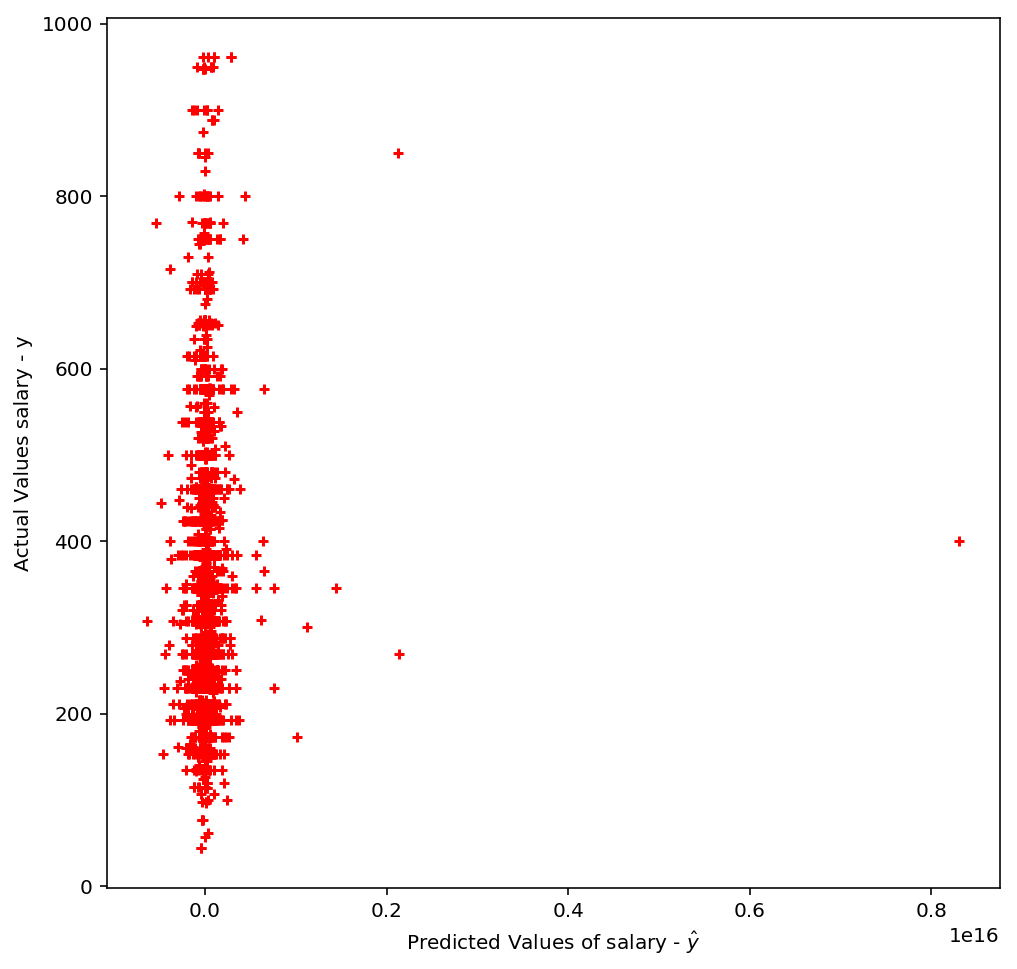

score:  -1.83932336689e+24


In [219]:
# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values of salary - $\hat{y}$")
plt.ylabel("Actual Values salary - y")
plt.show()

print "score: ", score

In [220]:
from collections import Counter

#to see how many columns have the same coefficients:
print len(model.coef_)-len(Counter(model.coef_).keys())

4542


In [221]:
#creating a dateframe for the coefficients and there X predictors:
# and sorting them to see which is the most impactful
coef=pd.DataFrame([model.coef_], columns=dummies.columns)
coef=coef.abs()
coef.sum().sort_values(ascending=False).head(10)

AssertionError: 99 columns passed, passed data had 10275 columns

### Decision Trees:

In [222]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# making the variables
X, Y = x_train, y_train

# classifier = DecisionTreeClassifier(criterion='gini',
#                                     max_depth=None)


regressor = DecisionTreeRegressor(criterion='mse',
                                  max_depth=5)
regress= regressor.fit(X, Y)

Y_pred = regressor.predict(x_test)
score  =  regress.score(x_test, y_test)

# decision trees can give us feature importances. the higher the number the more important
feature_importances = regressor.feature_importances_


In [223]:
print Y_pred
print score 

[ 367.70497427  367.70497427  562.1369863  ...,  442.96        562.1369863
  562.1369863 ]
0.199743240719


In [224]:
from sklearn.metrics import accuracy_score

In [226]:
#Predicting using cross validation of 5 
# predictions = cross_val_predict(regressor, x_test, y_test,cv=5)
score  =  cross_val_score(regressor, x_test, y_test,cv=5)

print score
print score.mean()
print score.std()
# print accuracy_score(y_test, predictions)

[ 0.294663    0.12581889  0.32449794  0.33342198  0.1827227 ]
0.252224901787
0.0829775684767


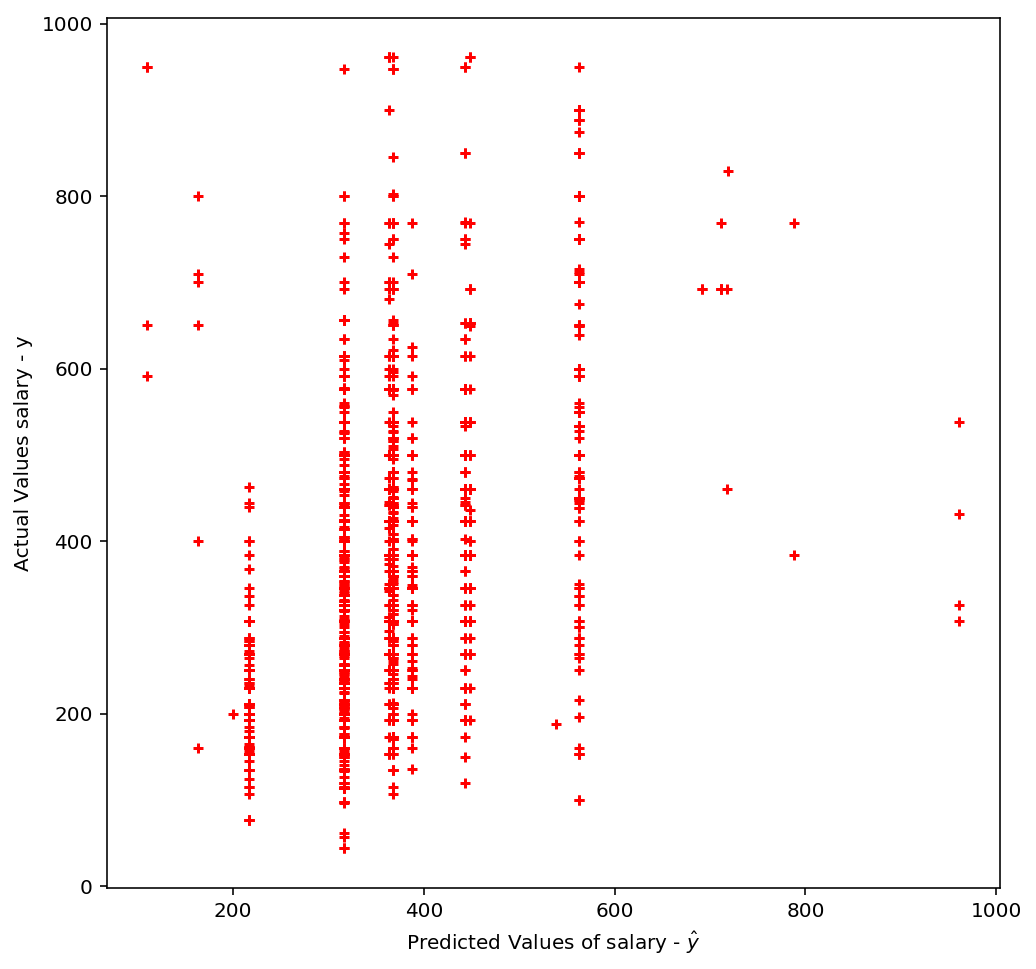

score:  [ 0.294663    0.12581889  0.32449794  0.33342198  0.1827227 ]


In [227]:
# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(Y_pred, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values of salary - $\hat{y}$")
plt.ylabel("Actual Values salary - y")
plt.show()

print "score: ", score

In [228]:
from collections import Counter

#to see how many columns have the same coefficients:
print len(feature_importances)-len(Counter(feature_importances).keys())

10252


In [230]:
#creating a dateframe for the coefficients and there X predictors:
# and sorting them to see which is the most impactful
trees_coef=pd.DataFrame([feature_importances], columns=dum.columns)
trees_coef=trees_coef.abs()
trees_coef.sum().sort_values(ascending=False)

class_Information & Communication Technology    0.323841
class_Administration & Office Support           0.159664
class_Construction                              0.081198
type_Contract/Temp                              0.073346
description_channel                             0.042087
area_CBD, Inner West & Eastern Suburbs          0.041780
description_business                            0.032523
description_great                               0.031784
title_solution architect                        0.029262
description_working                             0.028046
title_officer level                             0.027362
location_Sydney                                 0.020007
title_rise residential                          0.019856
description_hp                                  0.015989
title_sale manager                              0.015640
description_strong                              0.014059
description_developer                           0.012474
description_advanced           

### Conclusion

In [ ]:
#saving the dummies file to use in section 2
dummies.to_excel('./dummies.xls')

In [5]:
8*5*48*16

30720